In [1]:
import os
import matplotlib.pyplot as plt 
import numpy as np
import cv2
from collections import defaultdict, Counter
import yaml
from yaml.loader import SafeLoader
from PIL import Image
import imagehash
from tqdm.auto import tqdm
import os

In [2]:
TRAIN_IMAGES_PATH = os.path.join('PPEs.v4-raw.yolov8','train','images')
TRAIN_LEBELS_PATH = os.path.join('PPEs.v4-raw.yolov8','train','labels')
VALID_IMAGES_PATH = os.path.join('PPEs.v4-raw.yolov8','valid','images')
VALID_LEBELS_PATH = os.path.join('PPEs.v4-raw.yolov8','valid','labels')

train_files = ["".join(file.split('.')[:-1]) for file in os.listdir(TRAIN_IMAGES_PATH)]
valid_files = ["".join(file.split('.')[:-1]) for file in os.listdir(VALID_IMAGES_PATH)]

class_names= []
with open('PPEs.v4-raw.yolov8/data.yaml') as f:
    data = yaml.load(f, Loader=SafeLoader)
    class_names = data["names"]

TRAIN_SET_SIZE = len(train_files)
VALID_SET_SIZE = len(valid_files)

# Podział na zbiór treningowy i walidacyjny


/var/folders/dv/3lz4fq1n7sv4p3rrxgbjgpth0000gn/T/ipykernel_13390/2361065764.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


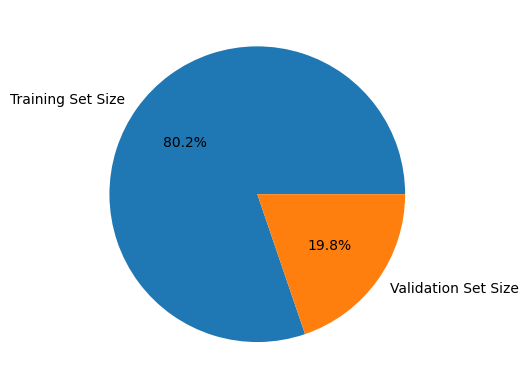

In [3]:
labels = ['Training Set Size', 'Validation Set Size']
sizes = [len(train_files), len(valid_files)]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
fig.show()

80.2% wszystkich zdjęć stanowi zestaw treningowy.


# Balans klas


#### Ilość klas


In [4]:
len(class_names)

12

## Częstotliwość występowania klas


In [5]:
train_classes_counter = defaultdict(int)
valid_classes_counter = defaultdict(int)

for filename in os.listdir(TRAIN_LEBELS_PATH):
    with open(os.path.join(TRAIN_LEBELS_PATH, filename), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_idx = line.split(' ')[0]
            train_classes_counter[int(class_idx)] += 1

for filename in os.listdir(VALID_LEBELS_PATH):
    with open(os.path.join(VALID_LEBELS_PATH, filename), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_idx = line.split(' ')[0]
            valid_classes_counter[int(class_idx)] += 1

train_classes_counter = defaultdict(int, sorted(train_classes_counter.items()))
valid_classes_counter = defaultdict(int, sorted(valid_classes_counter.items()))

Upewniam się, że w zbiorze treningowym wysępuje tyle samo ile w zbiorze walidacyjnym.


In [6]:
assert len(train_classes_counter) == len(valid_classes_counter)

## Graf przedstawiający ilość zdjęć należących do poszczególych zbiorów na klasę


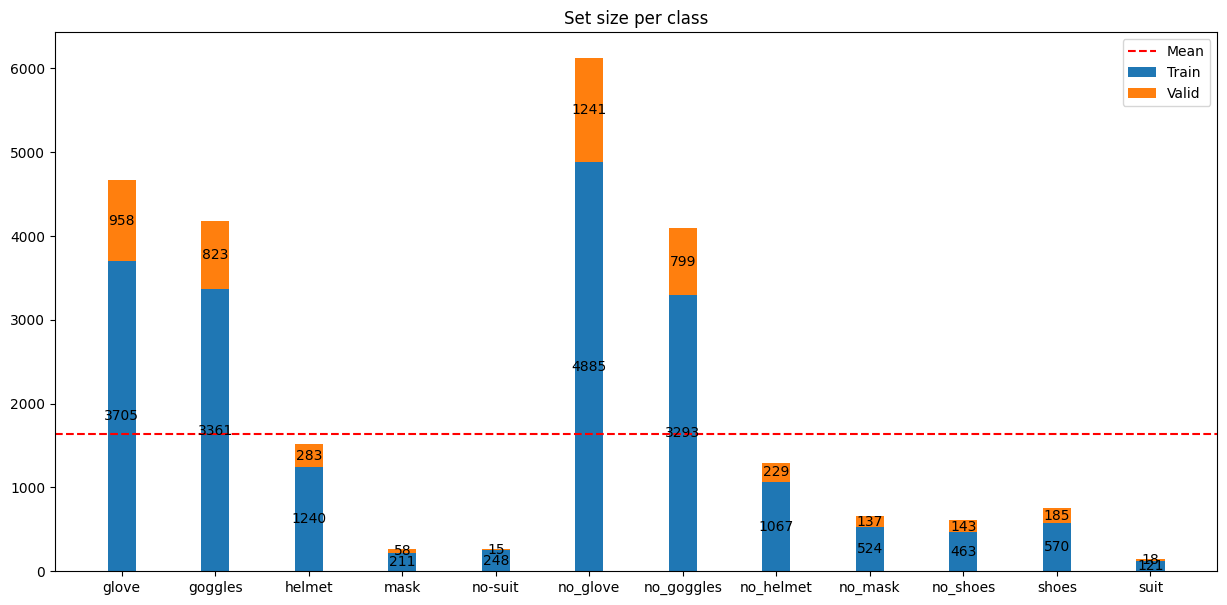

In [7]:
def mean(arr):
    return sum(arr)/len(arr)

mean_number_of_samples_per_class = mean(train_classes_counter.values())

set_counts = {
    'Train': np.array(list(train_classes_counter.values())),
    'Valid': np.array(list(valid_classes_counter.values())),
}
width = 0.3


fig, ax = plt.subplots(figsize=(15, 7))
bottom = np.zeros(len(class_names))

for set_name, set_count_per_class in set_counts.items():
    p = ax.bar(class_names, set_count_per_class, width, label=set_name, bottom=bottom)
    bottom += set_count_per_class

    ax.bar_label(p, label_type='center')

ax.axhline(mean_number_of_samples_per_class, color='red', linestyle='--', label='Mean')
ax.set_title('Set size per class')
ax.legend()

plt.show()

Jak możemu zauważyć, ilość zdjęć na klasę bardzo się różni. Na zdjęciach oznaczono 4885 razy klasę no_glove, a klasę suit tylko 121 razy.


### % jaki stanowi klasa w zbiorze treningowym


/var/folders/dv/3lz4fq1n7sv4p3rrxgbjgpth0000gn/T/ipykernel_13390/2012782575.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


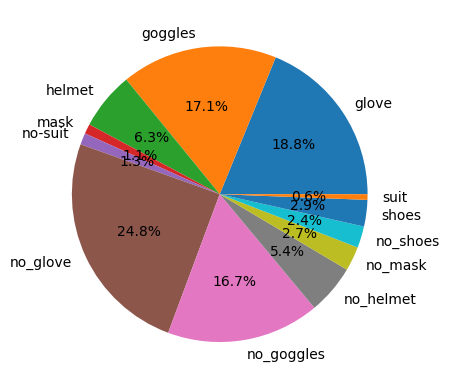

In [8]:
sizes = [samples for samples in train_classes_counter.values()]

fig, ax = plt.subplots()
ax.pie(sizes, labels=class_names, autopct='%1.1f%%')
fig.show()

### % jaki stanowi klasa w zbiorze walidacyjnym


/var/folders/dv/3lz4fq1n7sv4p3rrxgbjgpth0000gn/T/ipykernel_13390/1954860965.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


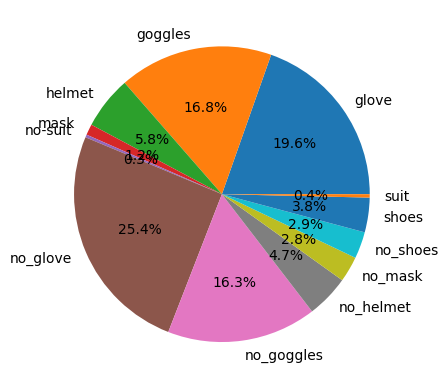

In [9]:
sizes = [samples for samples in valid_classes_counter.values()]

fig, ax = plt.subplots()
ax.pie(sizes, labels=class_names, autopct='%1.1f%%')
fig.show()

## Współczynnik rozmiaru zbioru treningowego i walidacyjnego na klasę


In [10]:
valid_train_ration_per_class = defaultdict(float)

for class_name, (valid_size, train_size) in zip(class_names, zip(valid_classes_counter.values(), train_classes_counter.values())):
    valid_train_ration_per_class[class_name] = valid_size/train_size

valid_train_ration_per_class = defaultdict(int, sorted(valid_train_ration_per_class.items(), reverse=True, key=lambda x: x[1]))
valid_train_ration_per_class

defaultdict(int,
            {'shoes': 0.32456140350877194,
             'no_shoes': 0.30885529157667385,
             'mask': 0.27488151658767773,
             'no_mask': 0.26145038167938933,
             'glove': 0.2585695006747638,
             'no_glove': 0.25404298874104403,
             'goggles': 0.2448675989288902,
             'no_goggles': 0.24263589432128757,
             'helmet': 0.22822580645161292,
             'no_helmet': 0.21462043111527648,
             'suit': 0.1487603305785124,
             'no-suit': 0.06048387096774194})

Powyżej możemy zauważyć, że bilans różni się w zależności od klasy. Dla klasy shoes jest to 0.32 a dla klasy no-suit 0.06.


# Zaznaczenia


In [11]:
train_points = defaultdict(list)
valid_points = defaultdict(list)
number_of_bounding_boxes_train = []
number_of_bounding_boxes_valid = []

for filename in os.listdir(TRAIN_LEBELS_PATH):
    with open(os.path.join(TRAIN_LEBELS_PATH, filename), "r") as f:
        lines = f.readlines()
        number_of_bbs = 0
        for line in lines:
            class_idx, center_x, center_y, *_ = line.split(' ')
            train_points[class_names[int(class_idx)]].append((center_x, center_y))
            number_of_bbs += 1
        number_of_bounding_boxes_train.append(number_of_bbs)

for filename in os.listdir(VALID_LEBELS_PATH):
    with open(os.path.join(VALID_LEBELS_PATH, filename), "r") as f:
        lines = f.readlines()
        number_of_bbs = 0
        for line in lines:
            class_idx, center_x, center_y, *_ = line.split(' ')
            valid_points[class_names[int(class_idx)]].append((center_x, center_y))
            number_of_bbs += 1
        number_of_bounding_boxes_valid.append(number_of_bbs)
        

## Ilość zaznaczeń


### Maksymalna, minimalna oraz średnia ilość zaznaczeń w poszczególnych zbiorach

#### Zbiór treningowy


In [12]:
max(number_of_bounding_boxes_train), min(number_of_bounding_boxes_train), mean(number_of_bounding_boxes_train)

(13, 1, 2.048486109666008)

#### Zbiór walidacyjny


In [13]:
max(number_of_bounding_boxes_valid), min(number_of_bounding_boxes_valid), mean(number_of_bounding_boxes_valid)

(10, 1, 2.0654837346852557)

### Najczęstsza ilość oznaczeń na zdjęciach

#### Zbiór treningowy


In [14]:
max(Counter(number_of_bounding_boxes_train).items(), key=lambda x: x[1])

(1, 4813)

##### Ilość, zdjęć na których znajdują sie poszczególne klasy


In [15]:
Counter(number_of_bounding_boxes_train)

Counter({1: 4813,
         3: 1078,
         2: 2211,
         4: 813,
         6: 201,
         5: 384,
         9: 8,
         7: 76,
         8: 20,
         10: 4,
         12: 2,
         13: 1})

#### Zbiór walidacyjny


In [16]:
max(Counter(number_of_bounding_boxes_valid).items(), key=lambda x: x[1])

(1, 1200)

##### Ilość, zdjęć na których znajdują sie poszczególne klasy


In [17]:
Counter(number_of_bounding_boxes_valid)

Counter({1: 1200, 2: 517, 4: 206, 3: 258, 5: 93, 7: 20, 6: 68, 10: 2, 8: 3})

## Rozmieszczenie zaznaczeń


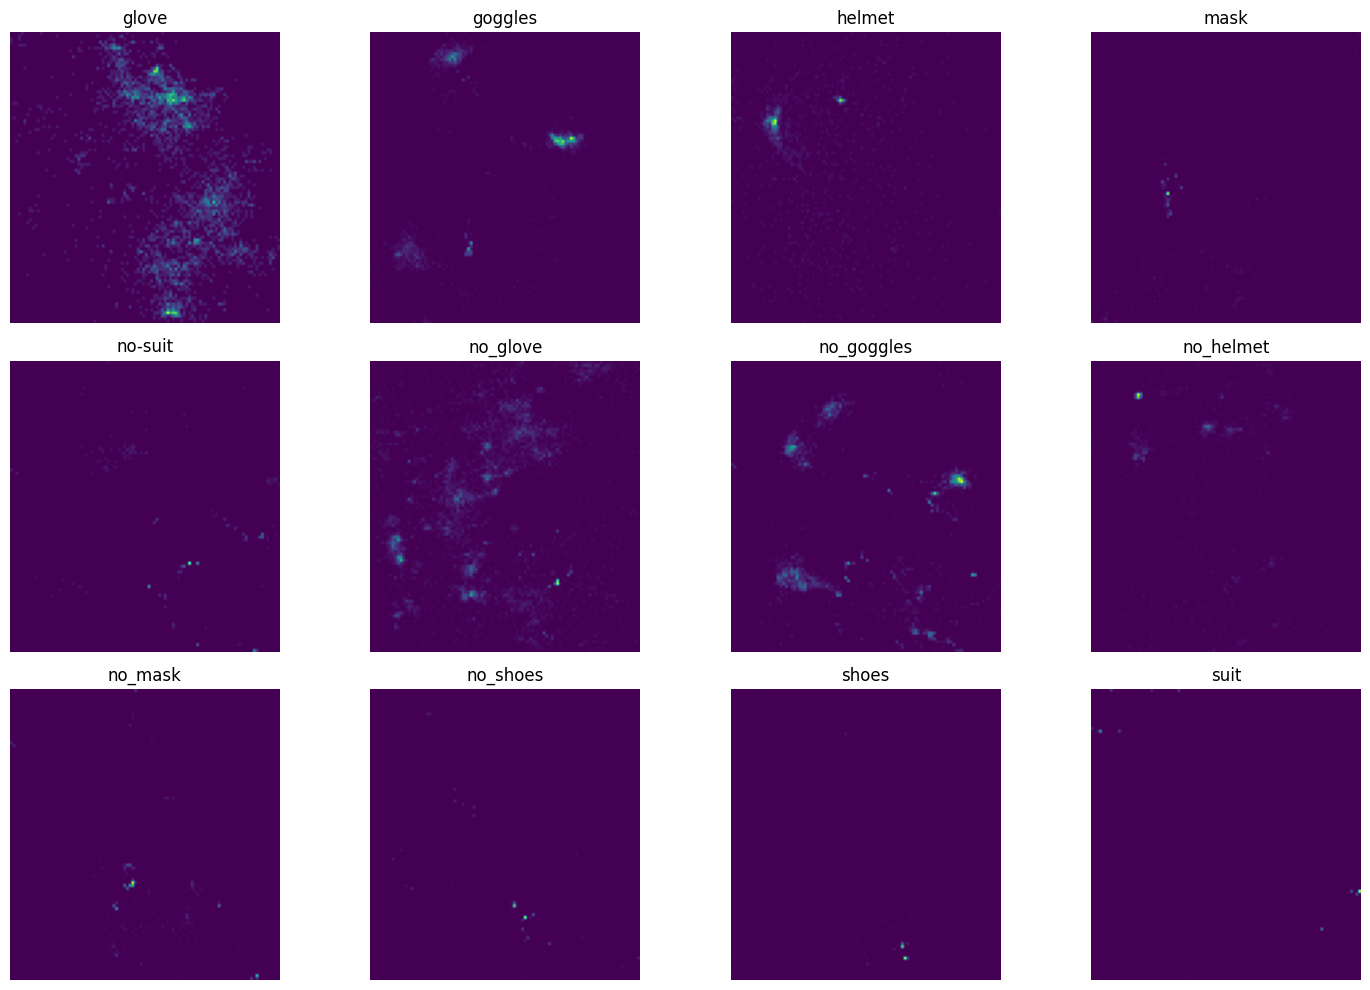

In [18]:
grid_size = (100, 100)

heatmaps = {}

for class_name, class_data in train_points.items():
    class_data = np.array(class_data, dtype=np.float32)
    heatmap, xedges, yedges = np.histogram2d(class_data[:, 0], class_data[:, 1], bins=grid_size)
    heatmaps[class_name] = heatmap

for class_name in heatmaps:
    heatmaps[class_name] /= heatmaps[class_name].sum()

num_rows, num_cols = 3, 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, class_name in enumerate(class_names):
    row = i // num_cols
    col = i % num_cols

    ax = axs[row, col]
    heatmap = heatmaps[class_name]
    ax.imshow(heatmap, cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    ax.set_title(class_name)
    ax.axis('off') 

for i in range(len(class_names), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axs[row, col])

plt.tight_layout()
plt.show()


Diagramy powyzej przedstawiaja rozmieszczenie klas na zdjeciach. Żadna klasa nie jest równomiernie rozłożona na zdjęciach. Najlepiej ze wszystkich prezetnują sie klasy glove oraz no_glove.


## Wielkość zaznaczeń


In [19]:
size_of_bounding_box_per_class_train = defaultdict(list)
size_of_bounding_box_per_class_valid = defaultdict(list)

for filename in os.listdir(TRAIN_LEBELS_PATH):
    with open(os.path.join(TRAIN_LEBELS_PATH, filename), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_idx, *_, width, height = line.split(' ')
            class_idx = int(class_idx)
            width = float(width)
            height = float(height)
            size_of_bounding_box_per_class_train[class_names[class_idx]].append(height*width)

for filename in os.listdir(VALID_LEBELS_PATH):
    with open(os.path.join(VALID_LEBELS_PATH, filename), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_idx, *_, width, height = line.split(' ')
            class_idx = int(class_idx)
            width = float(width)
            height = float(height)
            size_of_bounding_box_per_class_valid[class_names[class_idx]].append(height*width)

### Wyświelanaie średniego pola zaznaczeń dla poszczególnych klas (proporcjonalnie do rozmiaru zdjęć)


In [20]:
for class_name, data in size_of_bounding_box_per_class_train.items():
    print(f"{class_name:<10} {mean(data):<10}")


helmet     0.012101536666961572
goggles    0.00336432789394156
no_helmet  0.009102922390452881
glove      0.01394316767116131
no_glove   0.01045941833027212
no-suit    0.06439234108053225
no_shoes   0.0012757448937369513
shoes      0.0023690568313780402
suit       0.08248526202745672
no_goggles 0.0030281070942624663
mask       0.0021368647450331073
no_mask    0.0028657494675375437


# Zdjęcia

## Rozmiary zdjęć


In [21]:
train_image_sizes = []
valid_image_sizes = []

for image in os.listdir(TRAIN_IMAGES_PATH):
    image_path = os.path.join(TRAIN_IMAGES_PATH, image)
    img = cv2.imread(image_path)
    train_image_sizes.append(img.shape)

for image in os.listdir(VALID_IMAGES_PATH):
    image_path = os.path.join(VALID_IMAGES_PATH, image)
    img = cv2.imread(image_path)
    valid_image_sizes.append(img.shape)

In [22]:
train_image_sizes_counter = Counter(train_image_sizes)
valid_image_sizes_counter = Counter(valid_image_sizes)

#### Unikatowe rozmiary zdjęć


In [23]:
image_shapes = set([*train_image_sizes_counter.keys(), *valid_image_sizes_counter.keys()])

In [24]:
len(image_shapes)

111

Jest 111 unikatowych rozmiarów zdjęć


#### Minimalny i maksymlany rozmiar zdjęć


In [25]:
min_size = min(image_shapes, key=lambda x: x[0]*x[1])

In [26]:
max_size = max(image_shapes, key=lambda x: x[0]*x[1])

In [27]:
train_image_sizes_counter[min_size], valid_image_sizes_counter[min_size]

(1, 0)

W zbiorze treningowych występuje jedno zdjęcie o najmniejszym rozmiarze, a w zbiorze walidanycjnym ani jedno


In [28]:
train_image_sizes_counter[max_size], valid_image_sizes_counter[max_size]

(339, 93)

W zbiorze treningowych występuje 339 zdjęć o największym rozmiarze, a w zbiorze walidanycjnym 93


### Zbiór treningowy


/var/folders/dv/3lz4fq1n7sv4p3rrxgbjgpth0000gn/T/ipykernel_13390/3854674175.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


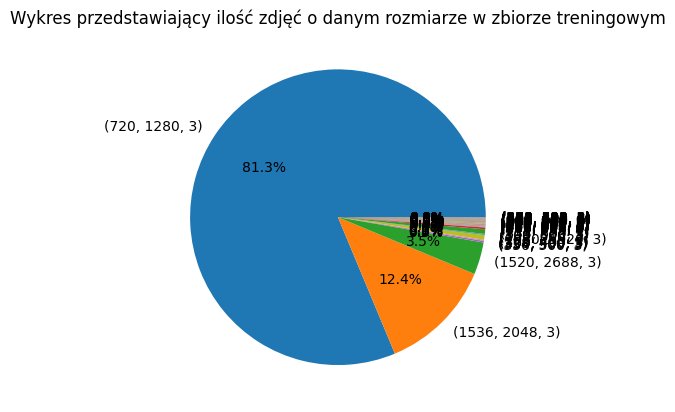

In [29]:
sizes = [samples for samples in train_image_sizes_counter.values()]

fig, ax = plt.subplots()
ax.pie(sizes, labels=[str(size) for size in train_image_sizes_counter.keys()], autopct='%1.1f%%')
ax.set_title("Wykres przedstawiający ilość zdjęć o danym rozmiarze w zbiorze treningowym")
fig.show()

#### 3 najpopularniejsze rozmiary


In [30]:
most_popular_sizes = list(sorted(train_image_sizes_counter.items(), key=lambda x: x[1], reverse=True))[:3]
[size[0] for size in most_popular_sizes]

[(720, 1280, 3), (1536, 2048, 3), (1520, 2688, 3)]

#### Suma zdjęć, których jest mniej niż ilość wystąpień trzeciego najpopularniejszego rozmiaru


In [31]:
sum([x[1] for x in list(filter(lambda x: x[1] < most_popular_sizes[-1][1], train_image_sizes_counter.items()))])

264

In [32]:
264/TRAIN_SET_SIZE

0.02746852564769535

Zdjęcia te stanowią tylko 2.7% zbioru traningowego


### Zbiór walidacyjny


/var/folders/dv/3lz4fq1n7sv4p3rrxgbjgpth0000gn/T/ipykernel_13390/1369540724.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


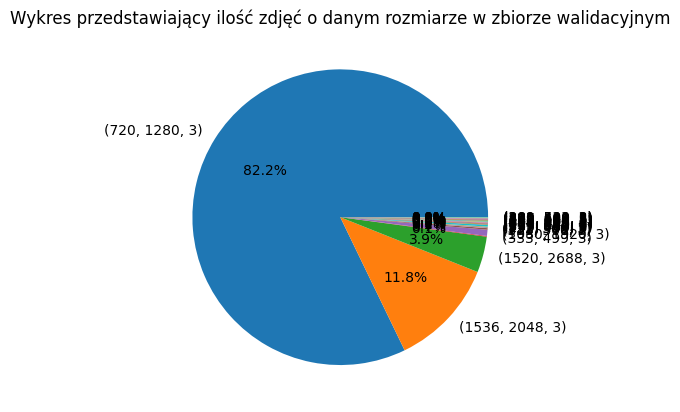

In [33]:
sizes = [samples for samples in valid_image_sizes_counter.values()]

fig, ax = plt.subplots()
ax.pie(sizes, labels=[str(size) for size in valid_image_sizes_counter.keys()], autopct='%1.1f%%')
ax.set_title("Wykres przedstawiający ilość zdjęć o danym rozmiarze w zbiorze walidacyjnym")
fig.show()

#### 3 najpopularniejsze rozmiary


In [34]:
most_popular_sizes = list(sorted(valid_image_sizes_counter.items(), key=lambda x: x[1], reverse=True))[:3]
[size[0] for size in most_popular_sizes]

[(720, 1280, 3), (1536, 2048, 3), (1520, 2688, 3)]

#### Suma zdjęć, których jest mniej niż ilość wystąpień trzeciego najpopularniejszego rozmiaru


In [35]:
sum([x[1] for x in list(filter(lambda x: x[1] < most_popular_sizes[-1][1], valid_image_sizes_counter.items()))])

50

In [36]:
50/VALID_SET_SIZE

0.021123785382340516

Zdjęcia te stanowią tylko 2.1% zbioru walidacyjnego


## Znajdowanie podobnych zdjęć

**Zdjęcia są podobne** jeżeli ich średnie hashe są podobne oraz na oby tych zdjęciach występują te same klasy.


In [37]:
def get_classes(image_path):
    dirs = image_path.split('/')
    label_path = os.path.join(*dirs[:-2], "labels", ".".join(dirs[-1].split('.')[:-1])+".txt")
    classes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            classes.append(line.split(' ')[0])
    classes.sort()
    return tuple(classes)

In [38]:
train_image_paths = [os.path.join(TRAIN_IMAGES_PATH, file) for file in os.listdir(TRAIN_IMAGES_PATH)]
valid_image_paths = [os.path.join(VALID_IMAGES_PATH, file) for file in os.listdir(VALID_IMAGES_PATH)]

train_image_paths_n_hashes = []
valid_image_paths_n_hashes = []
hash_size = 8

for image_path in tqdm(train_image_paths):
    with Image.open(image_path) as img:
        hash_ = imagehash.average_hash(img, hash_size).hash
        train_image_paths_n_hashes.append((image_path, hash_))

for image_path in tqdm(valid_image_paths):
    with Image.open(image_path) as img:
        hash_ = imagehash.average_hash(img, hash_size).hash
        valid_image_paths_n_hashes.append((image_path, hash_))

  0%|          | 0/9611 [00:00<?, ?it/s]

  0%|          | 0/2367 [00:00<?, ?it/s]

In [39]:
train_image_path2classes = {image_path: get_classes(image_path) for image_path in train_image_paths}
valid_image_path2classes = {image_path: get_classes(image_path) for image_path in valid_image_paths}

### Podobne zdjęcia ze zbioru treningowego do zdjęć ze zbioru walidacyjnego


In [40]:
similarity=95
threshold = 1 - similarity/100
diff_limit = int(threshold*(hash_size**2))
similar_images = set()
similar_images_pairs = []
all_combinations = 0

for train_path_filename, train_hash in tqdm(train_image_paths_n_hashes, total=len(train_image_paths_n_hashes)):
    train_image_classes = train_image_path2classes[train_path_filename]
    for valid_path_filename, valid_hash in valid_image_paths_n_hashes:
        all_combinations += 1
        valid_image_classes = valid_image_path2classes[valid_path_filename]
        if np.count_nonzero(train_hash != valid_hash) <= diff_limit and train_image_classes == valid_image_classes:
            similar_images_pairs.append((train_path_filename, valid_path_filename))
            similar_images.add(valid_path_filename)

  0%|          | 0/9611 [00:00<?, ?it/s]

In [41]:
len(similar_images)/VALID_SET_SIZE

0.8339670468948035

83.3% zdjęć ze zbioru walidacyjnego jest podobnych do zdjęć ze zbioru treningowego


/var/folders/dv/3lz4fq1n7sv4p3rrxgbjgpth0000gn/T/ipykernel_13390/560742158.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


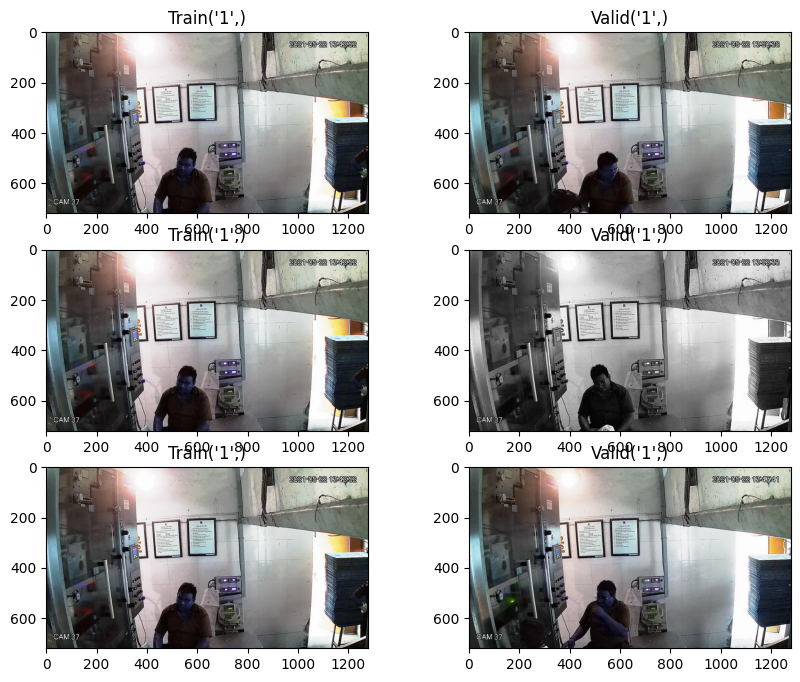

In [42]:
num_rows = 3
num_cols = 2
fig, axs = plt.subplots(num_rows,num_cols, figsize=(10, 8))
for i in range(num_rows):
    axs[i, 0].imshow(cv2.imread(similar_images_pairs[i][0]))
    str_train_classes = str(train_image_path2classes[similar_images_pairs[i][0]])
    axs[i, 0].set_title("Train"+str_train_classes)
    axs[i, 1].imshow(cv2.imread(similar_images_pairs[i][1]))
    str_valid_classes = str(valid_image_path2classes[similar_images_pairs[i][1]])
    axs[i, 1].set_title("Valid"+str_valid_classes)

fig.show()

Możemy zauważyć, że zdjęcia w zbiorze treningowym oraz walidacyjnym są bardzo podobne.


### Ilość podobnych zdjęć w zbiorze treningowym


In [43]:
threshold = 1 - similarity/100
diff_limit = int(threshold*(hash_size**2))
image_number_of_similar_images = defaultdict(list)
similar_images = set()
similar_images_pairs = []

for idx, (train_path_filename, train_hash) in tqdm(enumerate(train_image_paths_n_hashes), total=len(train_image_paths_n_hashes)):
    train_image_classes = train_image_path2classes[train_path_filename]
    for train_path_filename2, valid_hash in train_image_paths_n_hashes[idx+1:]:
        train_image_classes2 = train_image_path2classes[train_path_filename2]
        if np.count_nonzero(train_hash != valid_hash) <= diff_limit and train_image_classes==train_image_classes2:
            similar_images.add(train_path_filename)
            similar_images.add(train_path_filename2)
            similar_images_pairs.append((train_path_filename, train_path_filename2))

  0%|          | 0/9611 [00:00<?, ?it/s]

In [44]:
len(similar_images)/TRAIN_SET_SIZE

0.8350847986681927

83.5% zbioru treningowego jest do siebie podobny


/var/folders/dv/3lz4fq1n7sv4p3rrxgbjgpth0000gn/T/ipykernel_13390/699000685.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


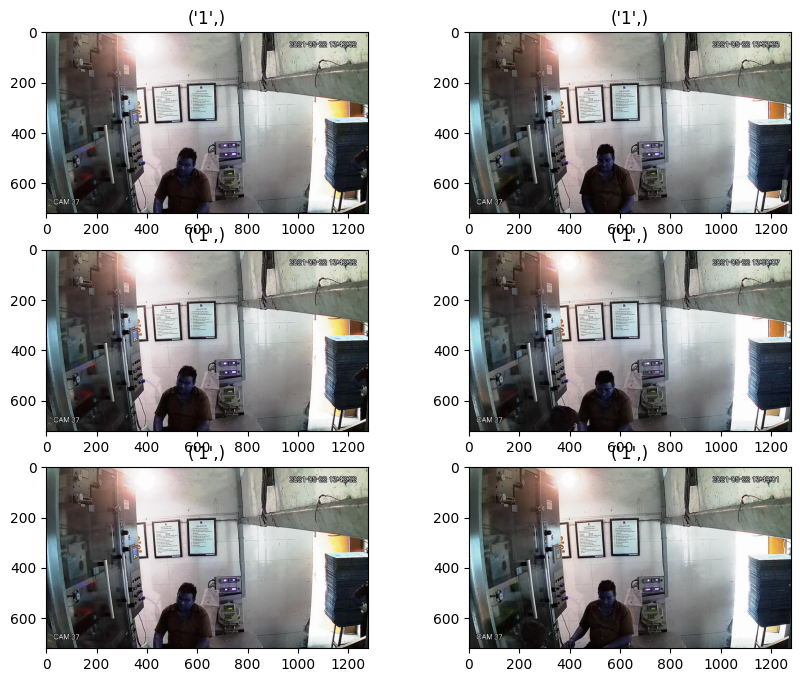

In [45]:
num_rows = 3
num_cols = 2
fig, axs = plt.subplots(num_rows,num_cols, figsize=(10, 8))
for i in range(num_rows):
    axs[i, 0].imshow(cv2.imread(similar_images_pairs[i][0]))
    classes1 = str(train_image_path2classes[similar_images_pairs[i][0]])
    axs[i, 0].set_title(classes1)
    axs[i, 1].imshow(cv2.imread(similar_images_pairs[i][1]))
    classes2 = str(train_image_path2classes[similar_images_pairs[i][1]])
    axs[i, 1].set_title(classes2)

fig.show()

### Ilość podobnych zdjęć w zbiorze walidacyjnym


In [46]:
threshold = 1 - similarity/100
diff_limit = int(threshold*(hash_size**2))
image_number_of_similar_images = defaultdict(list)
similar_images = set()
similar_images_pairs = []

for idx, (valid_path_filename, train_hash) in tqdm(enumerate(valid_image_paths_n_hashes), total=len(valid_image_paths_n_hashes)):
    valid_image_classes = valid_image_path2classes[valid_path_filename]
    for valid_path_filename2, valid_hash in valid_image_paths_n_hashes[idx+1:]:
        valid_image_classes2 = valid_image_path2classes[valid_path_filename2]
        if np.count_nonzero(train_hash != valid_hash) <= diff_limit and valid_image_classes == valid_image_classes2:
            similar_images.add(valid_path_filename)
            similar_images.add(valid_path_filename2)
            similar_images_pairs.append((valid_path_filename, valid_path_filename2))

  0%|          | 0/2367 [00:00<?, ?it/s]

In [47]:
len(similar_images)/VALID_SET_SIZE

0.7270806928601605

72.7% zbioru treningowego jest do siebie podobny


/var/folders/dv/3lz4fq1n7sv4p3rrxgbjgpth0000gn/T/ipykernel_13390/2715452247.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


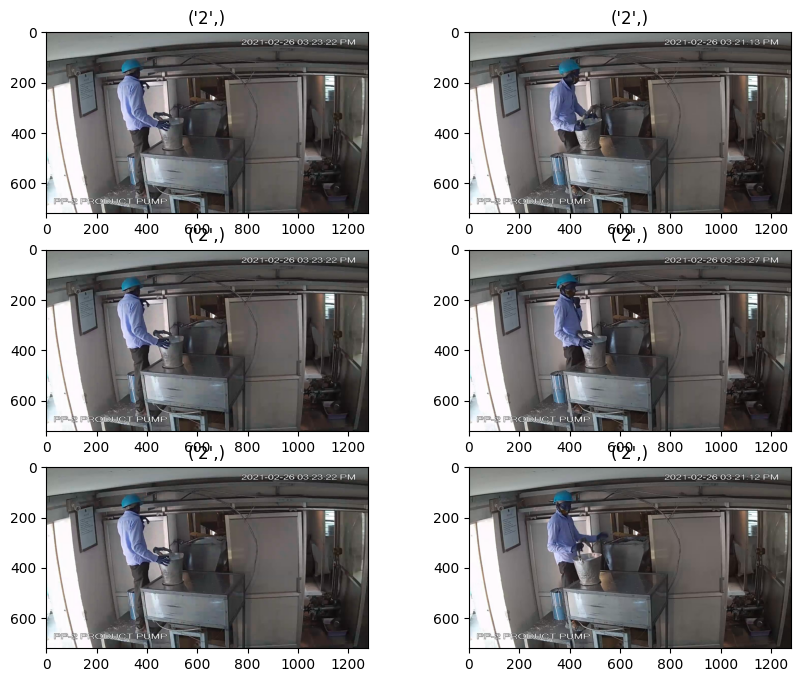

In [48]:
num_rows = 3
num_cols = 2
fig, axs = plt.subplots(num_rows,num_cols, figsize=(10, 8))
for i in range(num_rows):
    axs[i, 0].imshow(cv2.imread(similar_images_pairs[i][0]))
    classes1 = str(valid_image_path2classes[similar_images_pairs[i][0]])
    axs[i, 0].set_title(classes1)
    axs[i, 1].imshow(cv2.imread(similar_images_pairs[i][1]))
    classes2 = str(valid_image_path2classes[similar_images_pairs[i][1]])
    axs[i, 1].set_title(classes2)

fig.show()

# Wnioski

1. **Rozmiar zbiorów treningowego i walidacyjnego:** Zbiór treningowy zawiera 80% wszystkich dostępnych zdjęć, podczas gdy zbiór walidacyjny zawiera pozostałe 20%. Uważam, że podział jest zrobiony dobrze, aczkolwiek brakuje zbioru testującego.

2. **Balans klas:** Analiza pokazuje, że ilość zdjęć dla różnych klas jest bardzo nierównomierna. Na przykład klasa "no_glove" ma aż 4885 wystąpień w zbiorze treningowym, podczas gdy klasa "suit" ma tylko 121 wystąpień. To oznacza, że model może mieć trudności w nauczeniu się klas o mniejszej liczbie wystąpień.

3. **Ilość zaznaczeń:** Liczba zaznaczeń na zdjęciach w zbiorze treningowym i walidacyjnym jest zróżnicowana. Maksymalna liczba zaznaczeń na jednym obrazie w zbiorze treningowym wynosi 13, a w zbiorze walidacyjnym 10. Średnia liczba zaznaczeń na obrazie w zbiorze treningowym wynosi 2.05, a w zbiorze walidacyjnym 2.07.

4. **Rozmieszczenie zaznaczeń:** Analiza rozkładu zaznaczeń na obrazach pokazuje, że klasy nie są równomiernie rozłożone na zdjęciach. Większość klas jest bardziej skoncentrowane w określonych obszarach obrazu niż inne.

5. **Wielkość zaznaczeń:** Wielkość zaznaczeń różni się w zależności od klasy. Niektóre klasy mają większe zaznaczenia niż inne.

6. **Rozmiary zdjęć:** Analiza rozmiarów zdjęć w zbiorze treningowym i walidacyjnym pokazuje, że istnieją różne rozmiary obrazów. Znaleziono trzy najpopularniejsze rozmiary w każdym zbiorze, ale istnieje wiele innych rozmiarów obrazów, które stanowią około 2.5% każdego ze zbiorów.

7. **Podobne zdjęcia:** Znaleziono podobne zdjęcia w zbiorze treningowym do zbioru walidacyjnego na podstawie podobieństwa ich haszów. Warto zauważyć, że podobieństwo wynosiło 95%, co oznacza, że zdjęcia były bardzo podobne.

**Wniosek ogólny:**

Analiza zbioru danych wykazała, że istnieją pewne wyzwania związane z nierównomiernym rozkładem klas, różnymi rozmiarami obrazów i zróżnicowaną liczbą zaznaczeń.

**Odpowiedź na pytanie:**

Uważam, że zbiór danych nie jest wystarczający do przeprowadzenia treningu. Mimo sporej ilości danych, są one za mało różnorodne i powtarzalne.

**Proponowane kroki**:

- przeprowadzić augmentację danych (polecam bibliotekę albumentations) w celu różnorodengo rozmieszczenia zaznaczeń na zdjęciach, usunięcia problemu z podobnymi zdjęciami oraz zwiększenia bądź zmiejszenia zaznaczeń na zdjęciach

- zwiększyć ilość danych dla poszczególnych klas oraz rozmiarów zdjęć. Przykład: Yolov8 zmienia rozmiar obrazu na 640x640 więc dane powinny być na tyle zróżnicowane aby podczas transformacji zdjęć do tego rozmiaru nie było problemów z detekcją

- zwiększyć ilość zdjęć, aby był równy podział ze względu na ilość oznaczeń na zdjęciu

- zwiększyć ilość danych w celu wyrównania proporcji klas w zbiorze treningowym do klas w zbiorze walidacyjnym.
